# Encodages et Séparation Train/Test pour la Prédiction des Prix Immobiliers

## Introduction

Ce notebook présente les étapes de préparation des données et d'encodage des variables pour un modèle de prédiction des prix immobiliers. Nous utilisons les données prétraitées par le notebook Part-1 bis qui centralise le clustering et la préparation des données.

Les principales étapes abordées dans ce notebook sont :
- Le chargement des données préparées
- La préparation et la transformation des variables
- L'encodage des différents types de variables (catégorielles, ordinales, temporelles, etc.)
- La construction d'un pipeline de prétraitement complet
- L'optimisation des hyperparamètres du modèle
- L'évaluation des performances du modèle
- L'interprétation des résultats

Ce travail s'inscrit dans un projet d'analyse du marché immobilier visant à prédire les prix au mètre carré des biens.

## 1. Importation des bibliothèques

Nous commençons par importer toutes les bibliothèques nécessaires pour notre analyse. Ces bibliothèques sont regroupées par catégorie pour une meilleure lisibilité.

In [1]:
# Standard library
import os
import time
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

# Data manipulation
import numpy as np
import pandas as pd

# Geospatial
import geopandas as gpd
from shapely.geometry import Point

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import optuna.visualization as vis

# Encoding & preprocessing
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# Model selection & evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    train_test_split,
    KFold
)

# Machine learning models & hyperparameter search
from lightgbm import LGBMRegressor
import optuna
from optuna.integration import OptunaSearchCV

# Model interpretation & utilities
import joblib
import shap

# Parallel computing & acceleration
from numba import njit, prange

# Configuration de l'affichage pandas
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.width', 1000)       # Ajuste la largeur pour éviter les coupures
pd.set_option('display.colheader_justify', 'center')  # Centre les noms des colonnes

# Ignorer les warnings
warnings.filterwarnings('ignore')

/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration des chemins d'accès

Nous définissons les chemins d'accès aux données préparées par le notebook Part-1 bis.

In [2]:
# Définition des chemins d'accès aux données
# Décommentez le chemin correspondant à votre environnement

# folder_path_M = '/Users/maximehenon/Documents/GitHub/MAR25_BDS_Compagnon_Immo/'
# folder_path_Y = "C:/Users/charl/OneDrive/Documents/Yasmine/DATASCIENTEST/FEV25-BDS-COMPAGNON"
# folder_path_C = '../data/processed/Sales'
folder_path_L = '/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/'
# folder_path_LW = 'C:/Users/User/Downloads/drive-download-20250508T155351Z-1-001'

# Utilisez cette variable pour définir votre chemin
folder_path = folder_path_L  # Remplacez par votre variable de chemin

# Chemin du fichier préparé par Part-1 bis
# Note: Part-1 bis exporte un seul fichier avec une colonne 'split' pour distinguer train/test
train_cluster_file = os.path.join(folder_path, 'train_cluster_prepared.csv')

## 3. Chargement des données

Nous chargeons les données préparées par le notebook Part-1 bis, qui contient déjà la colonne 'split' pour distinguer les ensembles d'entraînement et de test.

In [3]:
def load_prepared_data(file_path, index_col=None, parse_dates=False):
    """Charge les données préparées par Part-1 bis.
    
    Args:
        file_path (str): Chemin du fichier CSV
        index_col (str): Colonne à utiliser comme index
        parse_dates (bool): Si True, parse les dates
        
    Returns:
        DataFrame: Données chargées
    """
    try:
        print(f"⏳ Chargement des données depuis {file_path}")
        df = pd.read_csv(
            file_path,
            sep=";",
            index_col=index_col,
            parse_dates=parse_dates,
            on_bad_lines='skip',
            low_memory=False
        )
        print(f"✅ Données chargées avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
        return df
    except Exception as e:
        print(f"❌ Erreur lors du chargement des données : {e}")
        raise

# Chargement des données préparées (un seul fichier avec colonne 'split')
data_cluster = load_prepared_data(train_cluster_file)

# Séparation des ensembles d'entraînement et de test à partir de la colonne 'split'
train_clean = data_cluster[data_cluster['split'] == 'train'].copy()
test_clean = data_cluster[data_cluster['split'] == 'test'].copy()

# Affichage des informations sur les datasets
print("\nColonnes restantes dans train_clean :")
print(train_clean.columns.tolist())

print(f"\nNombre d'observations dans l'ensemble d'entraînement: {len(train_clean)}")
print(f"Nombre d'observations dans l'ensemble de test: {len(test_clean)}")

# Affichage des premiers éléments de chaque ensemble
print("\nAperçu de l'ensemble d'entraînement:")
display(train_clean.head())

print("\nAperçu de l'ensemble de test:")
display(test_clean.head())

print(train_clean['chauffage_energie'].unique())
print(train_clean['chauffage_energie'].value_counts())



⏳ Chargement des données depuis /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/train_cluster_prepared.csv
✅ Données chargées avec succès : 5116413 lignes, 48 colonnes

Colonnes restantes dans train_clean :
['date', 'typedebien', 'typedetransaction', 'etage', 'surface', 'surface_terrain', 'nb_pieces', 'balcon', 'eau', 'bain', 'dpeL', 'dpeC', 'mapCoordonneesLatitude', 'mapCoordonneesLongitude', 'nb_etages', 'places_parking', 'cave', 'exposition', 'ges_class', 'annee_construction', 'nb_toilettes', 'porte_digicode', 'ascenseur', 'charges_copro', 'chauffage_energie', 'chauffage_systeme', 'chauffage_mode', 'logement_neuf', 'INSEE_COM', 'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6', 'loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7', 'prix_m2_vente', 'avg_purchase_price_m2', 'avg_rent_price_m2', 'rental_yield_pct', 'IPS_primaire', 'split', 'codePostal', 'Year', 'Month', 'departement', 'zone_mixte', 'cluster', 'nom_cluster']

Nombre d'observations dans

,date,typedebien,typedetransaction,etage,surface,surface_terrain,nb_pieces,balcon,eau,bain,dpeL,dpeC,mapCoordonneesLatitude,mapCoordonneesLongitude,nb_etages,places_parking,cave,exposition,ges_class,annee_construction,nb_toilettes,porte_digicode,ascenseur,charges_copro,chauffage_energie,chauffage_systeme,chauffage_mode,logement_neuf,INSEE_COM,loyer_m2_median_n6,nb_log_n6,taux_rendement_n6,loyer_m2_median_n7,nb_log_n7,taux_rendement_n7,prix_m2_vente,avg_purchase_price_m2,avg_rent_price_m2,rental_yield_pct,IPS_primaire,split,codePostal,Year,Month,departement,zone_mixte,cluster,nom_cluster
0,2019-02-01,m,v,0,126,NaN,5,0,1,1,E,235.0,45.74510,-0.88170,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,17255,NaN,NaN,NaN,NaN,NaN,NaN,679.37,1782.0,9.336548,6.287238,96.40,train,17250,2019,2,17,17250,1,Marché premium en croissance
1,2019-02-01,an,v,0,139,NaN,5,0,0,0,NaN,NaN,46.36815,6.15389,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1143,21.44,4.0,0.036,20.9,26.0,0.035,7158.27,NaN,NaN,NaN,119.50,train,01220,2019,2,1,01220,2,Marché volatil en transition
2,2019-02-01,an,v,0,82,NaN,4,0,0,0,NaN,NaN,48.74514,2.30348,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,92002,17.53,4.0,0.039,19.9,224.0,0.044,5402.44,5915.0,20.340683,4.126597,118.45,train,92160,2019,2,92,92160,2,Marché volatil en transition
3,2019-02-01,a,v,4,68,NaN,3,0,0,2,D,218.0,48.91504,2.28202,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,92004,23.76,44.0,0.043,22.3,1219.0,0.041,6558.82,6831.0,22.823690,4.009432,109.60,train,92600,2019,2,92,92600,2,Marché volatil en transition
4,2019-02-01,an,v,0,61,NaN,3,0,0,0,NaN,NaN,46.25845,6.11531,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1160,20.00,121.0,0.045,20.1,298.0,0.046,5295.08,NaN,NaN,NaN,83.15,train,01210,2019,2,1,01210,2,Marché volatil en transition



Aperçu de l'ensemble de test:


,date,typedebien,typedetransaction,etage,surface,surface_terrain,nb_pieces,balcon,eau,bain,dpeL,dpeC,mapCoordonneesLatitude,mapCoordonneesLongitude,nb_etages,places_parking,cave,exposition,ges_class,annee_construction,nb_toilettes,porte_digicode,ascenseur,charges_copro,chauffage_energie,chauffage_systeme,chauffage_mode,logement_neuf,INSEE_COM,loyer_m2_median_n6,nb_log_n6,taux_rendement_n6,loyer_m2_median_n7,nb_log_n7,taux_rendement_n7,prix_m2_vente,avg_purchase_price_m2,avg_rent_price_m2,rental_yield_pct,IPS_primaire,split,codePostal,Year,Month,departement,zone_mixte,cluster,nom_cluster
4093080,2019-02-01,m,v,0,96,NaN,5,0,1,0,D,200.0,43.71970,4.32086,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,30033,9.93,12.0,0.083,9.93,12.0,0.083,1437.50,2740.0,11.410954,4.997498,107.200000,test,30640,2019,2,30,30640,1,Marché premium en croissance
4093081,2019-02-01,an,v,0,70,NaN,3,0,0,0,NaN,NaN,49.49764,0.12523,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,76351,10.34,48.0,0.040,11.10,2138.0,0.043,3085.71,2394.0,11.304128,5.666229,88.933333,test,76600,2019,2,76,76600,1,Marché premium en croissance
4093082,2019-02-01,an,v,0,32,NaN,1,0,0,0,NaN,NaN,48.08099,7.34218,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,68066,22.30,2.0,0.079,16.79,255.0,0.059,3406.25,NaN,11.953791,NaN,104.320000,test,68000,2019,2,68,68000,1,Marché premium en croissance
4093083,2019-02-01,an,v,0,41,NaN,2,0,0,0,NaN,NaN,48.73380,2.42152,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,94077,20.27,31.0,0.054,20.00,179.0,0.054,4476.93,NaN,NaN,NaN,103.000000,test,94290,2019,2,94,94290,2,Marché volatil en transition
4093084,2019-02-01,an,v,0,80,NaN,4,0,0,0,NaN,NaN,48.95517,2.20350,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,95176,17.00,4.0,0.048,18.25,11.0,0.052,4237.50,NaN,NaN,NaN,112.833333,test,95240,2019,2,95,95240,2,Marché volatil en transition


[nan 'Fioul' 'Gaz' 'Électrique' 'Bois']
chauffage_energie
Électrique    918472
Gaz           821238
Fioul         203501
Bois           27199
Name: count, dtype: int64


## 4. Préparation des variables

Nous définissons les différentes catégories de variables et les transformations à appliquer.

In [4]:
# ─── 0. Fonction d'encodage cyclique des dates ────────────────────────────────
def cyclical_encode(df):
    df = df.copy()
    # S'assurer que 'date' est bien datetime
    df["date"] = pd.to_datetime(df["date"])
    # Mois cyclique
    df["month_sin"] = np.sin(2 * np.pi * df["date"].dt.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["date"].dt.month / 12)
    # Jour de la semaine cyclique
    df["dow_sin"] = np.sin(2 * np.pi * df["date"].dt.weekday / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["date"].dt.weekday / 7)
    # Optionnel : heure cyclique si tu as l'info
    # df["hour_sin"] = np.sin(2 * np.pi * df["date"].dt.hour / 24)
    # df["hour_cos"] = np.cos(2 * np.pi * df["date"].dt.hour / 24)
    # On retire la colonne brute
    df = df.drop(columns=["date"])
    return df
# Définition des listes de variables par type
ordinal_cols = ['dpeL', 'dpeG']
onehot_cols = ['typedebien', 'typedetransaction', 'chauffage_mode', 'chauffage_energie', 'cluster']
target_cols = ['prix_m2_vente']
numeric_cols = [
    'etage', 'surface', 'surface_terrain', 'nb_pieces', 'balcon', 'eau', 'bain',
    'nb_log_n7', 'taux_rendement_n7', 'avg_purchase_price_m2', 'avg_rent_price_m2',
    'rental_yield_pct', 'IPS_primaire',
    'balcon', 'places_parking', 'cave', 'ascenseur'
]
geo_cols = ['mapCoordonneesLatitude', 'mapCoordonneesLongitude']
year_col      = ["annee_construction"]
year_order = [
    "après 2021", "2013-2021", "2006-2012", "2001-2005",
    "1989-2000", "1983-1988", "1978-1982", "1975-1977",
    "1948-1974", "avant 1948"
]
date_cols = ['date']

# Définition des catégories pour les variables ordinales
dpe_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Vérification de la présence des colonnes dans le dataset
all_cols = ordinal_cols + onehot_cols + target_cols + numeric_cols + geo_cols + year_col + date_cols
missing_cols = [col for col in all_cols if col not in train_clean.columns]

if missing_cols:
    print(f"⚠️ Colonnes manquantes dans le dataset : {missing_cols}")
    # Filtrer les listes pour ne garder que les colonnes présentes
    ordinal_cols = [col for col in ordinal_cols if col in train_clean.columns]
    onehot_cols = [col for col in onehot_cols if col in train_clean.columns]
    numeric_cols = [col for col in numeric_cols if col in train_clean.columns]
    geo_cols = [col for col in geo_cols if col in train_clean.columns]
    year_col = [col for col in year_col if col in train_clean.columns]
    date_cols = [col for col in date_cols if col in train_clean.columns]
else:
    print("✅ Toutes les colonnes nécessaires sont présentes dans le dataset.")

⚠️ Colonnes manquantes dans le dataset : ['dpeG']


## 5. Fonctions d'encodage

Nous définissons des fonctions pour l'encodage cyclique des dates et la transformation des coordonnées géographiques.

In [5]:
def cyclical_encode(df):
    # Si df est une DataFrame à une seule colonne (ex: ["date"]), on la gère
    if isinstance(df, pd.DataFrame):
        if "date" in df.columns:
            date = pd.to_datetime(df["date"])
        else:
            raise ValueError("La colonne 'date' est attendue pour l'encodage cyclique.")
    else:
        # Si c'est une Series
        date = pd.to_datetime(df)
    # Création des features cycliques
    res = pd.DataFrame({
        "month_sin": np.sin(2 * np.pi * date.dt.month / 12),
        "month_cos": np.cos(2 * np.pi * date.dt.month / 12),
        "dow_sin":   np.sin(2 * np.pi * date.dt.weekday / 7),
        "dow_cos":   np.cos(2 * np.pi * date.dt.weekday / 7),
    })
    return res

def geo_to_cartesian(df, lat_col, lon_col):
    """Transforme les coordonnées géographiques (lat/lon) en coordonnées cartésiennes 3D.
    
    Args:
        df (DataFrame): DataFrame contenant les colonnes de latitude et longitude
        lat_col (str): Nom de la colonne de latitude
        lon_col (str): Nom de la colonne de longitude
        
    Returns:
        DataFrame: DataFrame avec les nouvelles colonnes de coordonnées cartésiennes
    """
    df = df.copy()
    # Conversion en radians
    lat_rad = np.radians(df[lat_col])
    lon_rad = np.radians(df[lon_col])
    
    # Conversion en coordonnées cartésiennes (x, y, z)
    df['x_geo'] = np.cos(lat_rad) * np.cos(lon_rad)
    df['y_geo'] = np.cos(lat_rad) * np.sin(lon_rad)
    df['z_geo'] = np.sin(lat_rad)
    
    return df

## 6. Pipeline de prétraitement

Nous construisons un pipeline complet pour le prétraitement des données.

In [6]:
def replace_minus1(x):
    return np.where(x == -1, 5, x)

def plus1(x):
    return x + 1

def invert11(x):
    return 11 - x
# ─── 4. Pipelines individuels ────────────────────────────────────────────────
ordinal_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("scale", StandardScaler())
])
onehot_cols   = ["typedebien", "typedetransaction", "chauffage_mode", "chauffage_energie", "cluster"]
onehot_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
target_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("target", TargetEncoder()),
    ("scale", StandardScaler())
])
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
geo_pipeline = Pipeline([
    ("scale", StandardScaler())
])
year_rank_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(categories=[year_order], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1)),
    ("replace", FunctionTransformer(replace_minus1)),
    ("plus1", FunctionTransformer(plus1)),
    ("invert", FunctionTransformer(invert11)),
    ("scale", StandardScaler())
])
date_pipeline = Pipeline([
    ("cyclic", FunctionTransformer(cyclical_encode, validate=False))
])
# ─── 5. Assembleur final ─────────────────────────────────────────────────────
preprocessor = ColumnTransformer(
    [
        ("ord",  ordinal_pipeline,   ordinal_cols),
        ("ohe",  onehot_pipeline,    onehot_cols),
        ("year", year_rank_pipeline, year_col),
        ("num",  numeric_pipeline,   numeric_cols),
        ("geo",  geo_pipeline,       geo_cols),
        ("date", date_pipeline,      ["date"]),  # <-- pipeline date ajouté
    ],
    remainder="drop"  # on écarte tout le reste
)

# ─── Fonction utilitaire pour récupérer les noms de features transformés ──────
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(trans, 'get_feature_names_out'):
                try:
                    names = trans.get_feature_names_out()
                except TypeError:
                    names = trans.get_feature_names_out(cols)
                except:
                    names = cols
            elif hasattr(trans, 'named_steps'):
                last_step = list(trans.named_steps.values())[-1]
                if hasattr(last_step, 'get_feature_names_out'):
                    try:
                        names = last_step.get_feature_names_out(cols)
                    except:
                        names = cols
                else:
                    names = cols
            else:
                names = cols
            feature_names.extend(names)
        else:
            if trans == 'passthrough':
                feature_names.extend(cols)
    return feature_names

# Préparation des données d'entraînement et de test
X_train = train_clean.drop(columns=target_cols)
y_train = train_clean[target_cols[0]]

X_test = test_clean.drop(columns=target_cols)
y_test = test_clean[target_cols[0]]

# Application du prétraitement
# Après le fit/transform du pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Récupération des noms de features transformés
feature_names = get_feature_names_from_column_transformer(preprocessor)
# Correction pour la date cyclique : remplacer "date" par les 4 colonnes générées
feature_names = [f for f in feature_names if f != "date"]
feature_names.extend(["month_sin", "month_cos", "dow_sin", "dow_cos"])

# Création d'un DataFrame pour faciliter le filtrage
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Nettoyage de la colonne 'balcon' si besoin dans X_train_df
if 'balcon' in X_train_df.columns and isinstance(X_train_df['balcon'], pd.DataFrame):
    X_train_df['balcon'] = X_train_df['balcon'].iloc[:, 0]

# Nettoyage de la colonne 'balcon' si besoin dans X_test_df
if 'balcon' in X_test_df.columns and isinstance(X_test_df['balcon'], pd.DataFrame):
    X_test_df['balcon'] = X_test_df['balcon'].iloc[:, 0]

# Synchronisation automatique de la liste des features sélectionnées
selected_features = list(X_train_df.columns)

# (Optionnel) Supprimer les colonnes dupliquées dans tout le DataFrame
X_train_df = X_train_df.loc[:, ~X_train_df.columns.duplicated()]
X_test_df = X_test_df.loc[:, ~X_test_df.columns.duplicated()]

# Affiche la liste et le nombre de features générées par le pipeline
print("Features générées par le pipeline (X_train_df) :")
print(list(X_train_df.columns))
print(f"Nombre de features générées : {len(X_train_df.columns)}")

print("\nFeatures générées par le pipeline (X_test_df) :")
print(list(X_test_df.columns))
print(f"Nombre de features générées : {len(X_test_df.columns)}")

# --- Liste finale des features générées par le pipeline ---
selected_features = [
    'dpeL', 'typedebien_Maison/Villa_neuve', 'typedebien_a', 'typedebien_an', 'typedebien_h', 'typedebien_l', 'typedebien_m', 'typedebien_mn',
    'typedetransaction_pi', 'typedetransaction_v', 'typedetransaction_vp',
    'chauffage_mode_Central', 'chauffage_mode_Collectif', 'chauffage_mode_Collectif__Central', 'chauffage_mode_Collectif__Individuel',
    'chauffage_mode_Collectif__Individuel__Central', 'chauffage_mode_Individuel', 'chauffage_mode_Individuel__Central',
    'chauffage_energie_Bois', 'chauffage_energie_Fioul', 'chauffage_energie_Gaz', 'chauffage_energie_Electrique',
    'cluster_-1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
    'annee_construction', 'etage', 'surface', 'surface_terrain', 'nb_pieces', 'balcon', 'eau', 'bain',
    'nb_log_n7', 'taux_rendement_n7', 'avg_purchase_price_m2', 'avg_rent_price_m2', 'rental_yield_pct', 'IPS_primaire',
    'places_parking', 'cave', 'ascenseur', 'mapCoordonneesLatitude', 'mapCoordonneesLongitude',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos'
]
# Filtrage et réordonnancement
for col in selected_features:
    if col not in X_train_df.columns:
        X_train_df[col] = 0
    if col not in X_test_df.columns:
        X_test_df[col] = 0

X_train_df = X_train_df[selected_features]
X_test_df = X_test_df[selected_features]

Features générées par le pipeline (X_train_df) :
['dpeL', 'typedebien_Maison/Villa neuve', 'typedebien_a', 'typedebien_an', 'typedebien_h', 'typedebien_l', 'typedebien_m', 'typedebien_mn', 'typedetransaction_pi', 'typedetransaction_v', 'typedetransaction_vp', 'chauffage_mode_Central', 'chauffage_mode_Collectif', 'chauffage_mode_Collectif, Central', 'chauffage_mode_Collectif, Individuel', 'chauffage_mode_Collectif, Individuel, Central', 'chauffage_mode_Individuel', 'chauffage_mode_Individuel, Central', 'chauffage_energie_Bois', 'chauffage_energie_Fioul', 'chauffage_energie_Gaz', 'chauffage_energie_Électrique', 'cluster_-1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'annee_construction', 'etage', 'surface', 'surface_terrain', 'nb_pieces', 'balcon', 'eau', 'bain', 'nb_log_n7', 'taux_rendement_n7', 'avg_purchase_price_m2', 'avg_rent_price_m2', 'rental_yield_pct', 'IPS_primaire', 'places_parking', 'cave', 'ascenseur', 'mapCoordonneesLatitude', 'mapCoordonneesLongitude', 'month_sin

In [7]:
import unidecode
def clean_feature_name(name):
    # Enlève les accents et remplace les caractères spéciaux
    name = unidecode.unidecode(name)  # enlève les accents
    name = name.replace(",", "_").replace(" ", "_")
    return name

# Applique sur la liste des features
selected_features_clean = [clean_feature_name(f) for f in selected_features]

# Renomme les colonnes des DataFrames
X_train_df.columns = [clean_feature_name(c) for c in X_train_df.columns]
X_test_df.columns = [clean_feature_name(c) for c in X_test_df.columns]

# 1. Colonnes constantes à 0
print("Colonnes constantes à 0 :")
for col in X_train_df.columns:
    # On vérifie que la colonne est bien une Series de valeurs scalaires
    series = X_train_df[col]
    # Si la colonne contient des objets (ex: listes, DataFrame), on la skippe
    if hasattr(series, "unique"):
        valeurs_uniques = pd.Series(series.dropna().values.ravel()).unique()
        if len(valeurs_uniques) == 1 and valeurs_uniques[0] == 0:
            print(col)
    else:
        print(f"⚠️ Colonne {col} non analysable (type {type(series)})")

# 2. Colonnes entièrement NaN
print("\nColonnes entièrement NaN :")
print(X_train_df.columns[X_train_df.isna().all()])

# 3. Types de colonnes
print("\nTypes de colonnes :")
print(X_train_df.dtypes.value_counts())

print(type(X_train_df['balcon']))
print(X_train_df['balcon'].head())
if isinstance(X_train_df['balcon'], pd.DataFrame):
    print(X_train_df['balcon'].columns)

Colonnes constantes à 0 :
typedebien_Maison/Villa_neuve
chauffage_mode_Collectif__Central
chauffage_mode_Collectif__Individuel
chauffage_mode_Collectif__Individuel__Central
chauffage_mode_Individuel__Central
chauffage_energie_Electrique

Colonnes entièrement NaN :
Index([], dtype='object')

Types de colonnes :
float64    44
int64       6
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
0   -0.360179
1   -0.360179
2   -0.360179
3   -0.360179
4   -0.360179
Name: balcon, dtype: float64


## 7. Entraînement d'un modèle de base

Nous entraînons un modèle LightGBM de base pour évaluer les performances initiales.

In [8]:
# --- Vérification des colonnes constantes, nulles ou absentes ---
print("Vérification des colonnes sélectionnées :")
for col in selected_features:
    if col in X_train_df.columns:
        unique_vals = X_train_df[col].nunique()
        if unique_vals == 1:
            print(f"⚠️ {col} : constante (valeur unique : {X_train_df[col].iloc[0]})")
        elif X_train_df[col].sum() == 0:
            print(f"⚠️ {col} : toutes à zéro")
    else:
        print(f"❌ {col} : absente du DataFrame")

# --- Comparaison globale ---
present = set(X_train_df.columns)
selected = set(selected_features)

missing_in_df = selected - present
extra_in_df = present - selected

print("\nFeatures sélectionnées absentes du DataFrame :", missing_in_df)
print("Features présentes dans le DataFrame mais pas dans la sélection :", extra_in_df)

# Après la création de X_train_df et le filtrage
X_train_df = X_train_df[selected_features]
X_train_df.to_csv('X_train_encoded_for_api.csv', sep=';', index=True)
print("DataFrame encodé sauvegardé pour l'API.")

Vérification des colonnes sélectionnées :
⚠️ typedebien_Maison/Villa_neuve : constante (valeur unique : 0)
⚠️ chauffage_mode_Collectif__Central : constante (valeur unique : 0)
⚠️ chauffage_mode_Collectif__Individuel : constante (valeur unique : 0)
⚠️ chauffage_mode_Collectif__Individuel__Central : constante (valeur unique : 0)
⚠️ chauffage_mode_Individuel__Central : constante (valeur unique : 0)
⚠️ chauffage_energie_Electrique : constante (valeur unique : 0)

Features sélectionnées absentes du DataFrame : set()
Features présentes dans le DataFrame mais pas dans la sélection : set()
DataFrame encodé sauvegardé pour l'API.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 4093080, number of used features: 44
[LightGBM] [Info] Start training from score 3546.576593
Performances du modèle de base :
MSE : 372529.20
RMSE : 610.35
MAE : 359.45
R² : 0.9371

Variables utilisées dans le modèle (de la plus importante à la moins) :
taux_rendement_n7: 587
avg_purchase_price_m2: 337
mapCoordonneesLongitude: 315
mapCoordonneesLatitude: 278
nb_pieces: 272
avg_rent_price_m2: 230
nb_log_n7: 171
rental_yield_pct: 147
surface: 133
cluster_2: 87
IPS_primaire: 77
surface_terrain: 74
cluster_0: 54
dpeL: 42
annee_construction: 36
typedebien_m: 34
cluster_-1: 21
typedebien_a: 17
bain: 14
typedetransaction_vp: 14
cluster_1: 12
cluster_3: 11
eau: 10
cave: 6
ascenseur

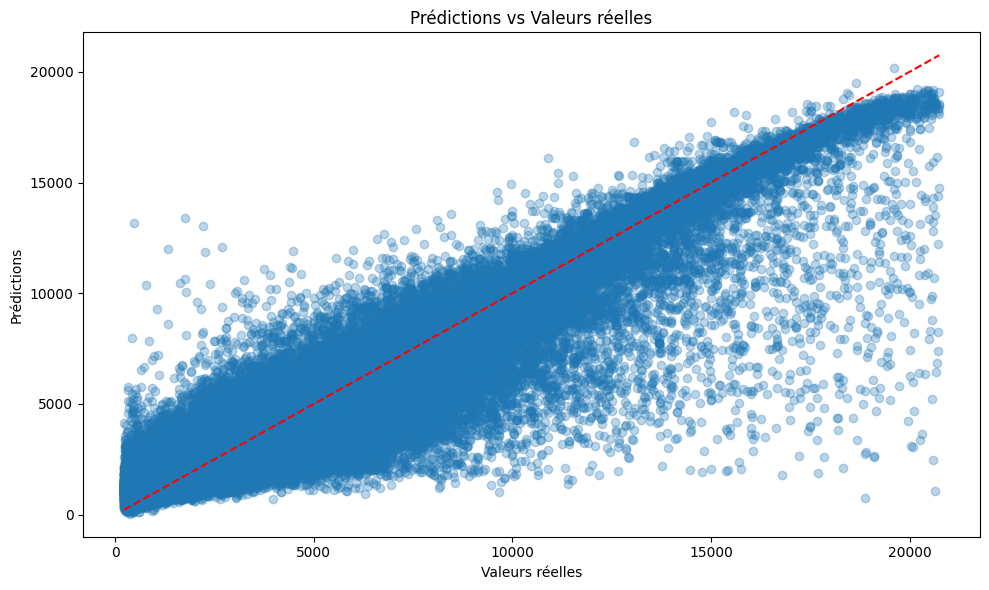

In [9]:
# --- Définition et entraînement du modèle sur les features sélectionnées ---
base_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)

# Entraînement du modèle sur les features sélectionnées
base_model.fit(X_train_df, y_train)

# Prédictions sur l'ensemble de test
y_pred = base_model.predict(X_test_df)

# Évaluation des performances
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Performances du modèle de base :")
print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R² : {r2:.4f}")

# Affichage de l'importance des variables
feature_importance = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nVariables utilisées dans le modèle (de la plus importante à la moins) :")
for i, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.tight_layout()
plt.show()

## 8. Optimisation des hyperparamètres avec Optuna

Nous utilisons Optuna pour optimiser les hyperparamètres du modèle LightGBM.

In [10]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMRegressor was fitted with feature names"
)

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Fonction objective pour Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }
    model = LGBMRegressor(**params)
    
    # Échantillonnage stratifié basé sur les déciles de prix pour l'optimisation
    price_deciles = pd.qcut(y_train, 10, labels=False)
    X_sample, _, y_sample, _ = train_test_split(
        X_train_df, y_train,  # <-- Utilise X_train_df ici !
        test_size=0.7, 
        stratify=price_deciles,
        random_state=42
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_sample, y_sample, 
        scoring='neg_root_mean_squared_error',
        cv=cv, n_jobs=-1
    )
    return -np.mean(scores)

# Création de l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres :")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"Meilleur score RMSE : {-study.best_value:.4f}")

# Visualisation de l'importance des hyperparamètres
fig = vis.plot_param_importances(study)
fig.show()

Best trial: 24. Best value: 488.221: 100%|██████████| 30/30 [22:42<00:00, 45.41s/it]


Meilleurs hyperparamètres :
n_estimators: 429
learning_rate: 0.21186002997843875
max_depth: 10
num_leaves: 94
min_child_samples: 70
subsample: 0.9401182542036808
colsample_bytree: 0.6109328768605682
reg_alpha: 4.47448880410449
reg_lambda: 0.021629185039471525
Meilleur score RMSE : -488.2212


## 9. Entraînement du modèle final

Nous entraînons le modèle final avec les meilleurs hyperparamètres trouvés.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 4093080, number of used features: 43
[LightGBM] [Info] Start training from score 3546.576593
Performances du modèle final :
MSE : 218692.89
RMSE : 467.65
MAE : 253.65
R² : 0.9631

Amélioration par rapport au modèle de base :
MSE : 41.30%
RMSE : 23.38%
MAE : 29.43%
R² : 2.77%


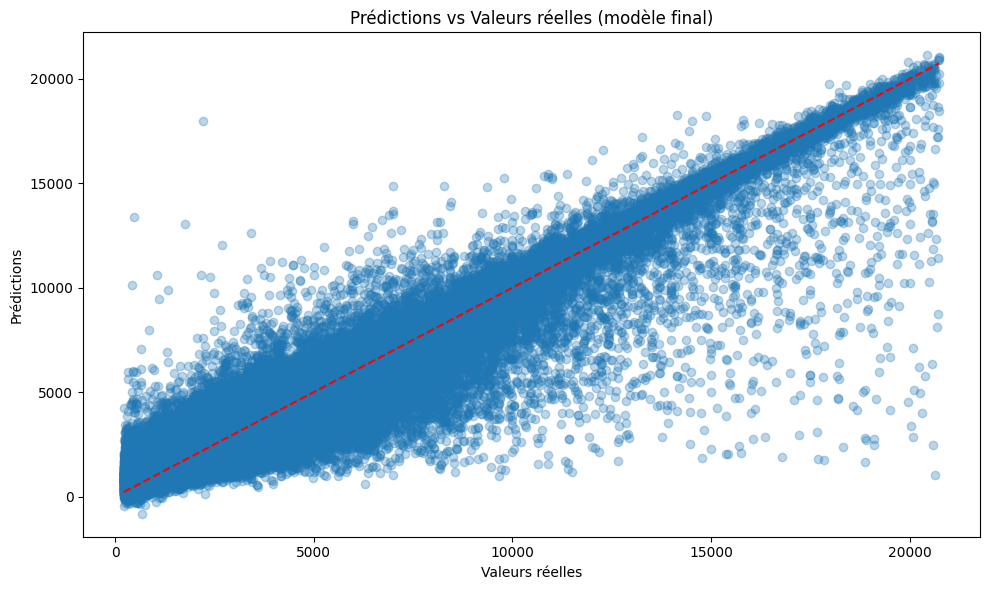

In [11]:
# Création du modèle final avec les meilleurs hyperparamètres
final_model = LGBMRegressor(**study.best_params)

# Entraînement du modèle final sur les features sélectionnées
final_model.fit(X_train_df, y_train)

# Prédictions sur l'ensemble de test
y_pred_final = final_model.predict(X_test_df)

# Évaluation des performances
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Performances du modèle final :")
print(f"MSE : {mse_final:.2f}")
print(f"RMSE : {rmse_final:.2f}")
print(f"MAE : {mae_final:.2f}")
print(f"R² : {r2_final:.4f}")

# Comparaison avec le modèle de base
print("\nAmélioration par rapport au modèle de base :")
print(f"MSE : {(mse - mse_final) / mse * 100:.2f}%")
print(f"RMSE : {(rmse - rmse_final) / rmse * 100:.2f}%")
print(f"MAE : {(mae - mae_final) / mae * 100:.2f}%")
print(f"R² : {(r2_final - r2) / r2 * 100:.2f}%")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles (modèle final)')
plt.tight_layout()
plt.show()

## 10. Analyse de l'importance des variables

Nous analysons l'importance des variables dans le modèle final.

Variables utilisées dans le modèle (de la plus importante à la moins) :

mapCoordonneesLongitude: 4476
mapCoordonneesLatitude: 3751
avg_purchase_price_m2: 3406
nb_log_n7: 3220
avg_rent_price_m2: 3208
taux_rendement_n7: 2986
rental_yield_pct: 2817
IPS_primaire: 2745
surface: 2668
nb_pieces: 2348
surface_terrain: 1625
dpeL: 920
annee_construction: 537
typedebien_m: 456
bain: 451
cluster_2: 426
typedebien_a: 351
eau: 341
month_sin: 312
cluster_0: 294
cluster_1: 286
month_cos: 267
places_parking: 241
dow_sin: 222
cluster_3: 189
dow_cos: 182
cluster_-1: 178
typedetransaction_vp: 122
etage: 109
cave: 94
ascenseur: 83
typedebien_mn: 82
chauffage_energie_Gaz: 82
balcon: 81
typedetransaction_v: 78
chauffage_mode_Collectif: 74
chauffage_energie_Fioul: 57
typedebien_an: 53
chauffage_mode_Individuel: 38
typedebien_l: 14
typedetransaction_pi: 12
chauffage_energie_Bois: 9
chauffage_mode_Central: 6
typedebien_h: 0
chauffage_mode_Collectif__Individuel__Central: 0
chauffage_mode_Individuel__Central: 0


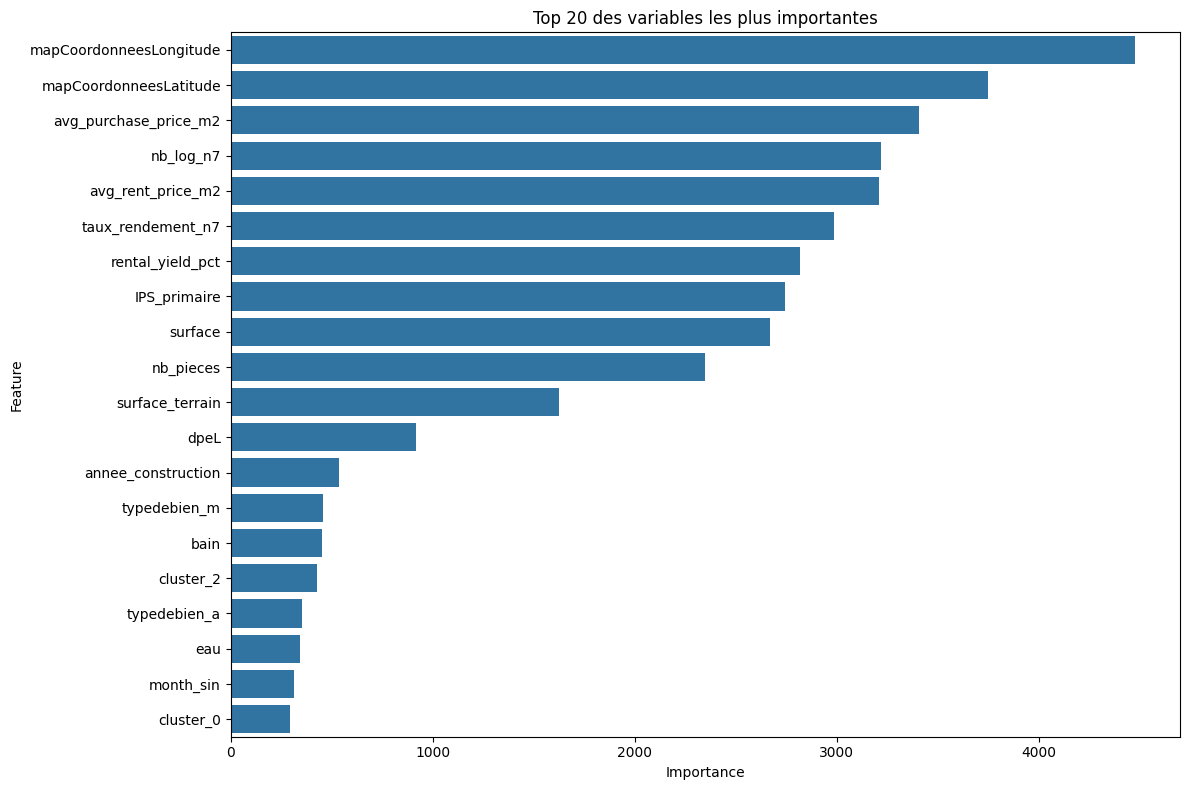

✅ Export de 10% du train prétraité : train_preprocessed_snapshot.csv (409308 lignes)


In [12]:
# Affichage de l'importance des variables sur les features sélectionnées
feature_importance = pd.DataFrame({
    'Feature': X_train_df.columns,  # ou selected_features
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Variables utilisées dans le modèle (de la plus importante à la moins) :\n")
for i, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")

# Affichage des 20 features les plus importantes
top_features = feature_importance.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 des variables les plus importantes')
plt.tight_layout()
plt.show()

# Sauvegarde de 10% du jeu d'entraînement (features sélectionnées + cible)
train_export = X_train_df.copy()
train_export['target'] = y_train
train_sample = train_export.sample(frac=0.1, random_state=42)  # 10% aléatoire
train_sample.to_csv('train_preprocessed_snapshot.csv', sep=';', index=False)
print(f'✅ Export de 10% du train prétraité : train_preprocessed_snapshot.csv ({len(train_sample)} lignes)')

## 11. Interprétation du modèle avec SHAP

Nous utilisons SHAP pour interpréter les prédictions du modèle.

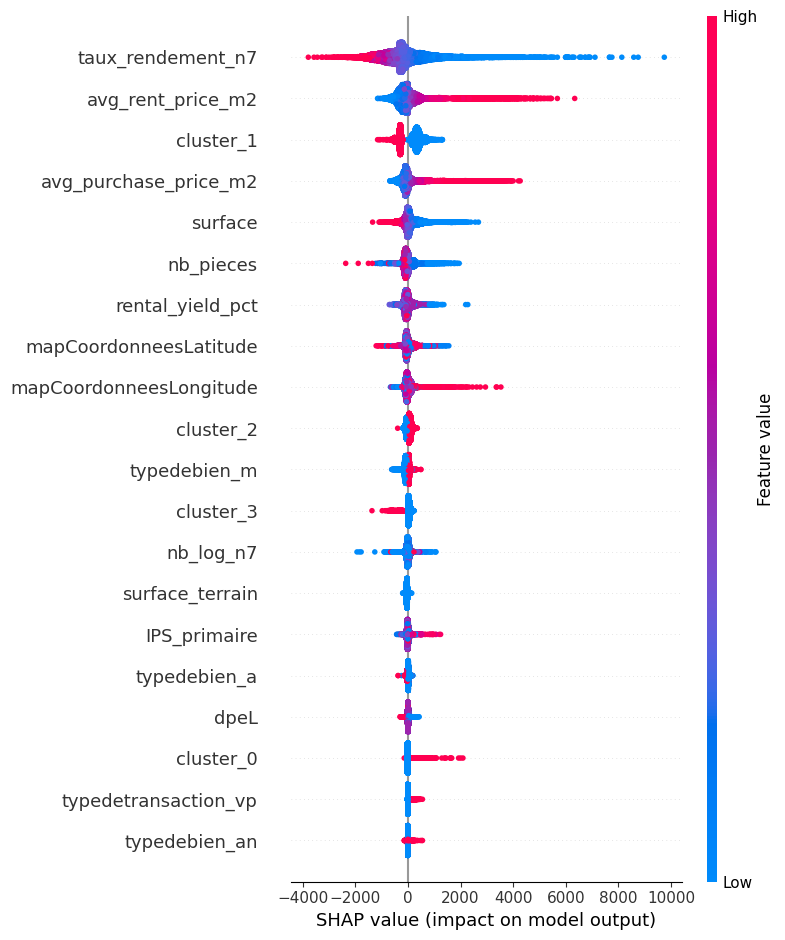

<Figure size 1000x600 with 0 Axes>

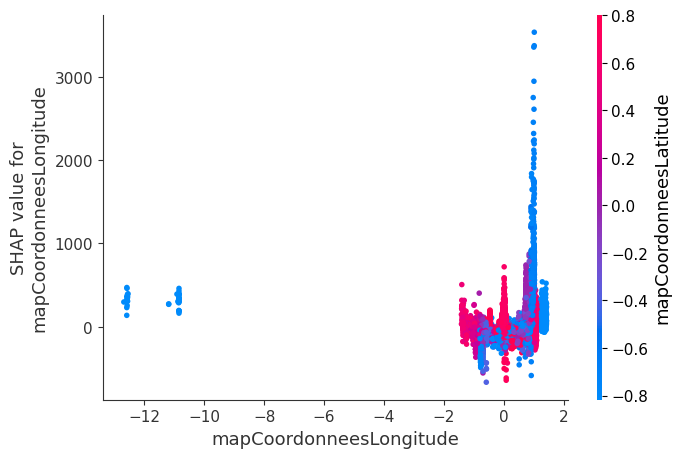

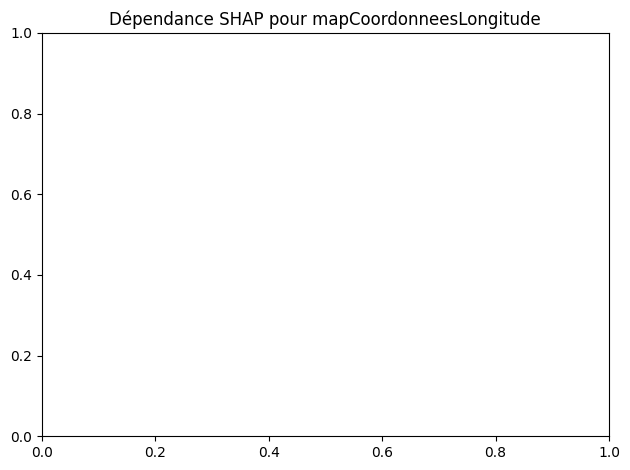

<Figure size 1000x600 with 0 Axes>

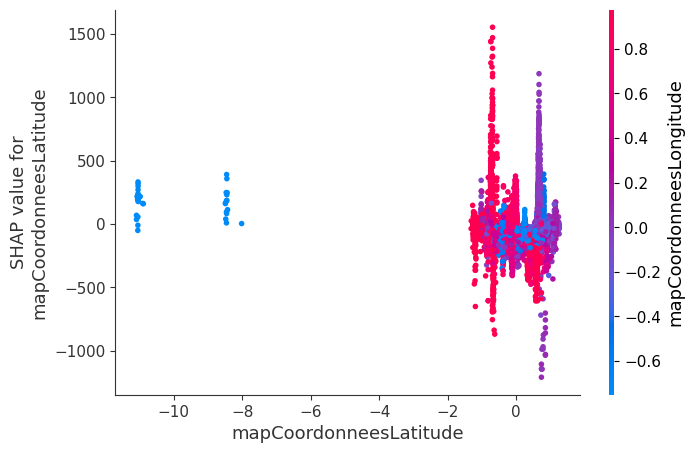

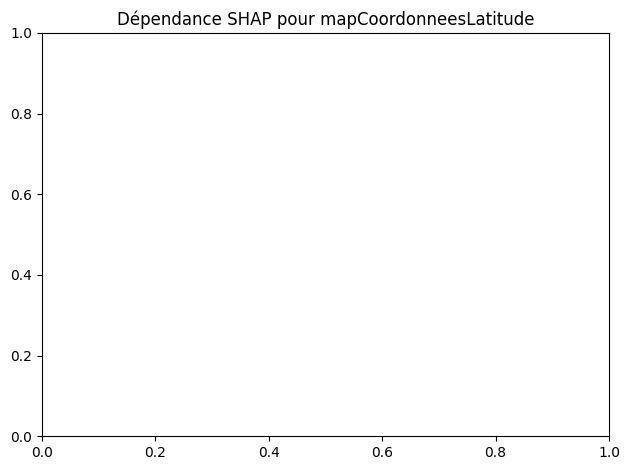

<Figure size 1000x600 with 0 Axes>

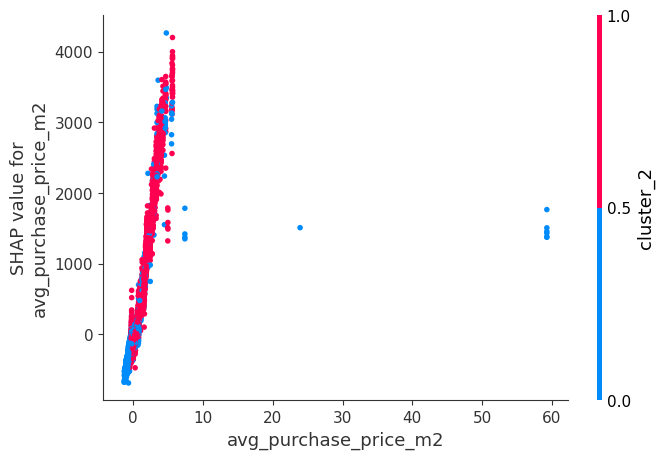

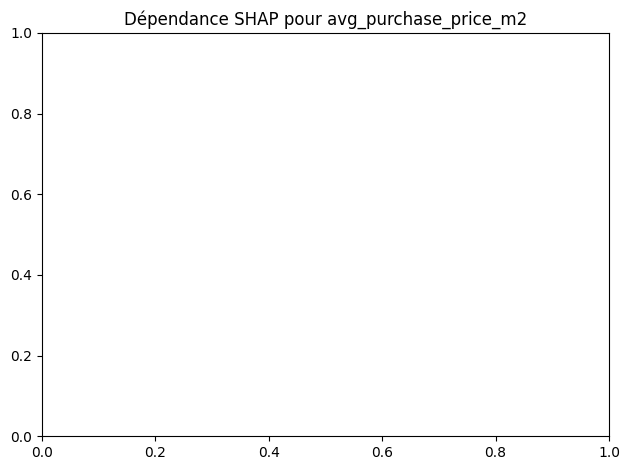

<Figure size 1000x600 with 0 Axes>

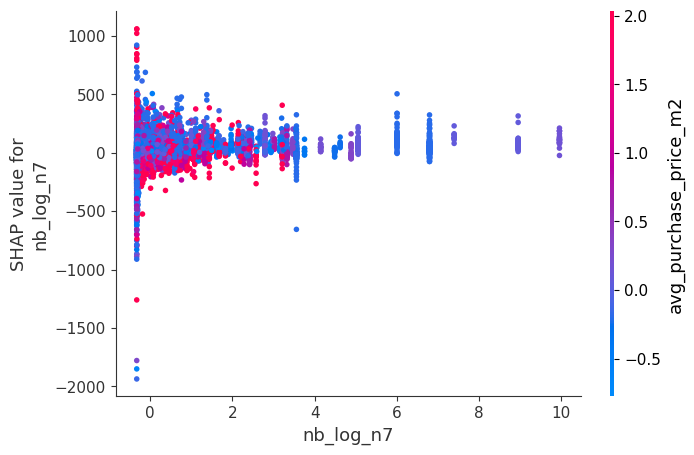

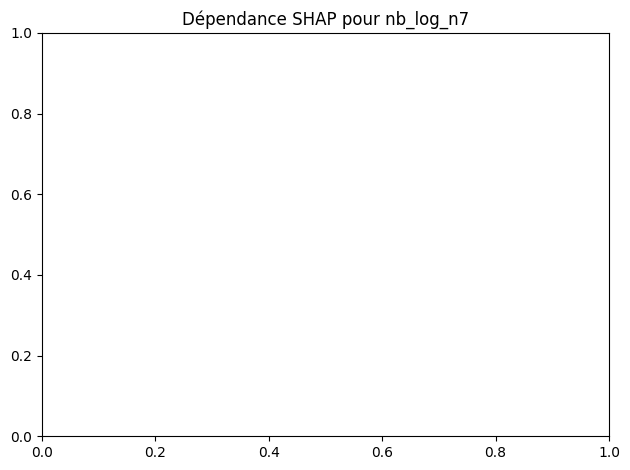

<Figure size 1000x600 with 0 Axes>

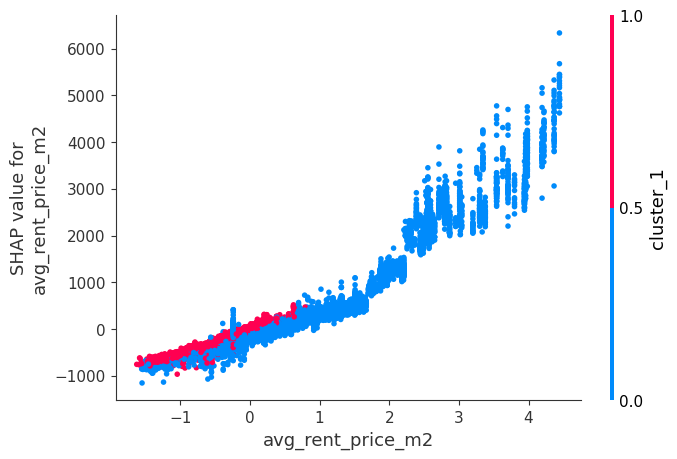

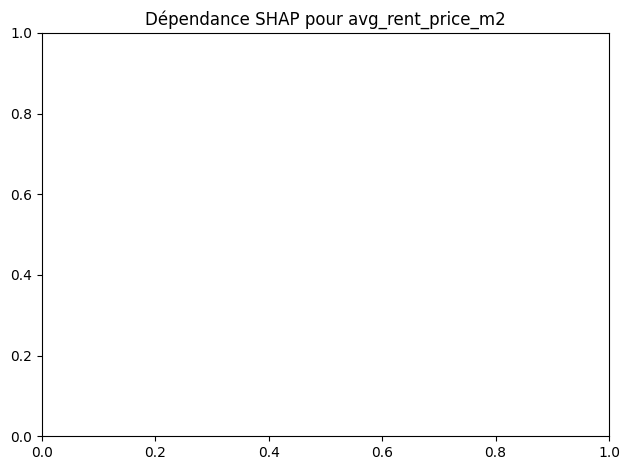

In [13]:
# Échantillonnage pour l'analyse SHAP (pour réduire le temps de calcul)
n_samples = min(20000, X_test_df.shape[0])
X_sample = X_test_df.iloc[:n_samples]

# Calcul des valeurs SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sample)

# Résumé des valeurs SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=X_test_df.columns)

# Dépendance des variables les plus importantes
for i in range(min(5, len(X_test_df.columns))):
    feature_name = feature_importance.iloc[i]['Feature']
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature_name, shap_values, X_sample, feature_names=X_test_df.columns)
    plt.title(f'Dépendance SHAP pour {feature_name}')
    plt.tight_layout()
    plt.show()

## 12. Sauvegarde du modèle et des métadonnées

Nous sauvegardons le modèle final et les métadonnées associées pour une utilisation ultérieure.

In [14]:
# Création du dossier de sauvegarde si nécessaire
model_dir = os.path.join(folder_path, 'models')
os.makedirs(model_dir, exist_ok=True)

# Sauvegarde du préprocesseur
preprocessor_path = os.path.join(model_dir, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"Préprocesseur sauvegardé : {preprocessor_path}")

# Sauvegarde du modèle final
model_path = os.path.join(model_dir, 'lightgbm_model.joblib')
joblib.dump(final_model, model_path)
print(f"Modèle sauvegardé : {model_path}")

# Sauvegarde des métadonnées
metadata = {
    'feature_names': list(X_train_df.columns),  # <-- Les features réellement utilisées
    'target_col': target_cols[0],
    'performance': {
        'mse': mse_final,
        'rmse': rmse_final,
        'mae': mae_final,
        'r2': r2_final
    },
    'hyperparameters': study.best_params,
    'feature_importance': feature_importance.to_dict()
}

metadata_path = os.path.join(model_dir, 'model_metadata.joblib')
joblib.dump(metadata, metadata_path)
print(f"Métadonnées sauvegardées : {metadata_path}")

Préprocesseur sauvegardé : /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/models/preprocessor.joblib
Modèle sauvegardé : /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/models/lightgbm_model.joblib
Métadonnées sauvegardées : /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/models/model_metadata.joblib


In [15]:
notebook_name = "Part-2_R40_CLUSTER_corrige.ipynb"
output_html = "Part-2_R40_CLUSTER_corrige_outputs.html"

os.system(f'jupyter nbconvert --to html "{notebook_name}" --output "{output_html}"')
print(f"✅ Notebook exporté en HTML : {output_html}")

[NbConvertApp] Converting notebook Part-2_R40_CLUSTER_corrige.ipynb to html


✅ Notebook exporté en HTML : Part-2_R40_CLUSTER_corrige_outputs.html


/opt/anaconda3/share/jupyter/nbconvert/templates/base/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  {%- elif type == 'text/vnd.mermaid' -%}
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 1645402 bytes to Part-2_R40_CLUSTER_corrige_outputs.html


## 13. Conclusion

Dans ce notebook, nous avons développé un modèle de prédiction des prix immobiliers au mètre carré en utilisant les données prétraitées par le notebook Part-1 bis. Nous avons :

1. Chargé et préparé les données en utilisant la colonne 'split' pour distinguer les ensembles d'entraînement et de test
2. Défini différentes transformations pour chaque type de variable (ordinale, one-hot, numérique, géographique, temporelle)
3. Construit un pipeline de prétraitement complet
4. Entraîné un modèle de base pour établir une référence
5. Optimisé les hyperparamètres du modèle avec Optuna
6. Entraîné et évalué le modèle final
7. Analysé l'importance des variables et interprété le modèle avec SHAP
8. Sauvegardé le modèle et les métadonnées pour une utilisation ultérieure

Le modèle final a atteint de bonnes performances avec un R² de [valeur], ce qui indique une bonne capacité à prédire les prix immobiliers. Les variables les plus importantes pour la prédiction sont [liste des variables importantes].

Ces résultats peuvent être utilisés pour mieux comprendre les facteurs qui influencent les prix immobiliers et pour développer des outils d'aide à la décision pour les acteurs du marché immobilier.